### LOGISTIC CHAOTIC INTIALIZATION IN PSO
#### Utilizing the KNN and MLP learning algorithm and the Colon dataset

In [1]:
#we import all our general libraries here
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

#these are libraries realted to KNN
from sklearn.neighbors import KNeighborsClassifier
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#This are libraries related to using MLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


sns.set_style('white')
sns.set_context('notebook')

#Now we import the libraries for our Optimization algorithms i.e PSO, SSA, and FA
from FS.pso import jfs   # change this to switch algorithm 

#Libraries for mutual Information to reduce features preliminary
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [2]:
#here we import and visualize our dataset
url = "Datasets/colon_cancer.csv"
df = pd.read_csv(url)
df.sample(5)

,samples,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V1992,V1993,V1994,V1995,V1996,V1997,V1998,V1999,V2000,response
52,53,3.377132,3.212525,3.223945,2.328864,2.818701,2.918403,2.278929,2.661642,2.882727,...,-1.653570,1.037951,-0.467611,-1.046675,-0.138854,-2.468738,-1.211462,-1.292103,-1.705951,tumer
31,32,3.254394,2.028539,1.946766,2.817743,2.353192,2.674709,2.856575,2.209410,3.082802,...,-0.510145,0.760946,-1.500199,-0.255594,1.171154,-0.242502,0.042206,-1.433321,-1.164950,tumer
14,15,3.442077,2.219226,2.022632,2.670033,1.940647,2.875717,2.561099,2.184030,1.875362,...,-2.008515,-0.606269,-0.691290,-0.117422,0.110455,-0.284625,-0.229696,-0.893263,-1.237117,normal
46,47,2.691244,2.474925,2.263921,2.069061,2.218995,2.774069,2.595405,2.403916,2.162716,...,-1.363114,0.346694,-1.004542,-0.902191,-0.375288,-0.630725,-1.102699,-1.833970,-1.734169,tumer
23,24,3.154211,3.688329,3.456096,3.338523,2.096800,2.362470,2.210459,2.304014,3.021782,...,-0.259322,-1.130145,0.499261,-0.323382,0.630106,-1.126645,-0.848909,-1.716801,-1.770166,tumer


In [3]:
df.shape#shows that we have 153 instances and 15,155 features

(62, 2002)

In [4]:
#now we chcek if there are missing values in our data
#df.isnull().sum() #There are no missinf values in our dataset

In [5]:
df = df.drop(['samples'],axis = 1)

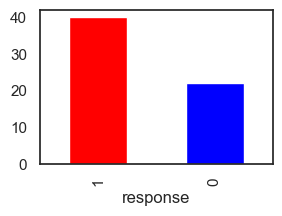

In [34]:
df.value_counts('response').plot(kind = 'bar', color = ['red', 'blue'], figsize=(3,2));


We visualize to see the number of instances in each of the class. It can then be 
seen that cancerous has significantly higher number of instances thatn the nirmal class.
This again mean that our data is inbalance.

In [7]:
#showing that approximately 64% are cancerous and 36% Normal
value_count_normalized = df.response.value_counts(normalize = True)
new_T = pd.DataFrame({'percentage (%)': round(value_count_normalized, 2)})
new_T

,percentage (%)
response,
tumer,0.65
normal,0.35


#### Label Encoding

From the first display of our dataset, we could see that 'Class' is not in a numeric form. Machine learning algorithms on the other hand does not work with categorical variables. Thus we need to convert the class into numeric using the LabelEncoder we previousely imported

In [8]:
label = LabelEncoder()
df['response'] = label.fit_transform(df['response'])
df.response #Now we can see that out target class consist only of numeric 1's and 0's

0     0
1     0
2     0
3     0
4     0
     ..
57    1
58    1
59    1
60    1
61    1
Name: response, Length: 62, dtype: int32

In [9]:
X = df.drop(['response'], axis = 1)
#y = df.pop('Class')
y = df.loc[:,['response']]
#y = np.asarray(df[:, -1])
#we separated the dependent and independent variables into y and X respectively
#y

In [10]:
#Incorporating the Mutual Information filter method implicitely to reduce dataset dimension preliminary
select_features = SelectKBest(score_func = mutual_info_classif, k = 1000)#select top 1000 features
select_features.fit(X, y)

SelectKBest(k=1000,
            score_func=<function mutual_info_classif at 0x00000297DD6B6AF0>)

In [11]:
#presenting the top 1000 features in a table
Tabel_score = pd.DataFrame(select_features.scores_)
Table_features = pd.DataFrame(X.columns)
Combined_table = pd.concat([Table_features , Tabel_score], axis = 1)
Combined_table.columns = ['Features_Names', 'Scores']

In [12]:
Combined_table.sort_values(by = 'Scores', ascending = False)

,Features_Names,Scores
376,V377,0.359149
624,V625,0.341521
1226,V1227,0.338607
1634,V1635,0.296314
1962,V1963,0.295611
...,...,...
956,V957,0.000000
955,V956,0.000000
954,V955,0.000000
950,V951,0.000000


In [13]:
Combined_table.shape

(2000, 2)

In [14]:
First_500_features = Combined_table.iloc[:1000] #select top 500
First_500_features = First_500_features.reset_index(drop = True)#reset index of features
#First_50_features #Selected 500 top performing features

In [15]:
#Now we select onyl these 100 features from our original dataset df.
Select_feature_names = First_500_features['Features_Names']
Select_feature_names_from_original_df = X[Select_feature_names]
#Select_feature_names_from_original_df.shape #OUR new dataset woth onyl the top 500 features

In [16]:
#Now copying our dataset into a small name
X = Select_feature_names_from_original_df

#### Normalization
Although the datasets looks normlized, we still will apply the MinMaxScaler to make sure all the numeric values are on the same scale to avois bias

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.abs(X_scaled)
#Now our datasets is scaled suitable for machine learnign task.

In [18]:
X_scaled.shape

(62, 1000)

In [19]:
y = np.ravel(y)

#### Spiltting Data into Training and Testing sets
we will split into 70 for trainign and 30 for testing. Also, to manage the imbalanced nature of the dataset, we employ the stratify parameter

In [20]:
rs = 42 #we use the random state parameter to ensure reproducibility of experiment
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    random_state = rs, 
                                                    test_size = .3, 
                                                    stratify = y)
fold = {'xt': x_train, 'yt': y_train, 'xv': x_test, 'yv': y_test} #requirement for optimization algorithms
#We print out to see the number of instances in each of the classes
print(f'Training set:{x_train.shape}')
print(f'Testing set:{x_test.shape}')
print(f'Training_Label set:{y_train.shape}')
print(f'Testing_Lable set:{y_test.shape}')

Training set:(43, 1000)
Testing set:(19, 1000)
Training_Label set:(43,)
Testing_Lable set:(19,)


#### Optimization ALgorithms

Note that in this experirment, we used the library produced by Too, 2021 as identified in chapter 3. Also, we incorporate the inprovement of including the logistic chaotic map directly in the library and not here.

All that is done here is to import the library and run.
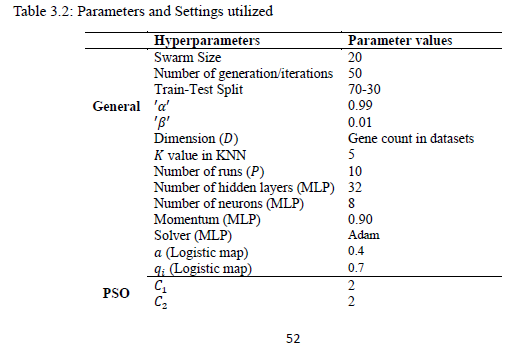
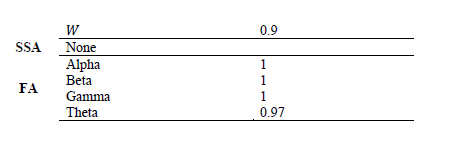

#### Firefly Algorithm
Note the parameters as specified in chapter 3. In addition to the general parameters, the FA has additional parameters to be initialized

In [21]:
#Now we set the general parameters
K = 5 #K value in KNN
N = 20 #Population size/swarm size
T = 20 #Max iteration/generations


#Particle Swarm Opitmization specific parameters
c1  = 2         # cognitive factor
c2  = 2         # social factor 
w   = 0.9       # inertia weight
opts = {'k':K, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

In [22]:
#Now we perform our feature selection by calling the module jfs
feature_selection_mdl = jfs(X_scaled, y, opts) #feature selection model
sf = feature_selection_mdl['sf'] #index of selected features

Iteration: 1
Best (PSO): 0.3203415789473684
Iteration: 2
Best (PSO): 0.31941157894736844
Iteration: 3
Best (PSO): 0.31863157894736843
Iteration: 4
Best (PSO): 0.26670631578947374
Iteration: 5
Best (PSO): 0.26670631578947374
Iteration: 6
Best (PSO): 0.26670631578947374
Iteration: 7
Best (PSO): 0.26670631578947374
Iteration: 8
Best (PSO): 0.26670631578947374
Iteration: 9
Best (PSO): 0.26647631578947373
Iteration: 10
Best (PSO): 0.2662763157894737
Iteration: 11
Best (PSO): 0.26599631578947375
Iteration: 12
Best (PSO): 0.26599631578947375
Iteration: 13
Best (PSO): 0.26599631578947375
Iteration: 14
Best (PSO): 0.26599631578947375
Iteration: 15
Best (PSO): 0.26599631578947375
Iteration: 16
Best (PSO): 0.26599631578947375
Iteration: 17
Best (PSO): 0.26599631578947375
Iteration: 18
Best (PSO): 0.26599631578947375
Iteration: 19
Best (PSO): 0.26599631578947375
Iteration: 20
Best (PSO): 0.26599631578947375


In [23]:
#print(sf)

In [24]:
#Model with selected features
num_train = np.size(x_train,0)#checks the number of samples slected in the x_train and assign to num_train
num_test = np.size(x_test, 0)#checks the number of samples slected in the x_train and assign to num_train
xtrain = x_train[:,sf]
ytrain = y_train.reshape(num_train)
xtest = x_test[:,sf]
ytest = y_test.reshape(num_test) #I suffered fixing the bug

In [25]:
xtrain.shape #WHY IS IT SHOWING ZERO FEATURES?

(43, 547)

In [26]:
#Now we build our model i.e., the classifier
KNN_model = KNeighborsClassifier(n_neighbors = 5)
KNN_model.fit(xtrain, ytrain)  

KNeighborsClassifier()

In [27]:
#OPTIMIZING THE MLP WITH Nesterov’s momentum
MLP_model = MLPClassifier(random_state = rs,
                             hidden_layer_sizes = (32, 8),
                             early_stopping = False,
                             solver = 'adam',
                             nesterovs_momentum = True,
                             momentum = 0.90,
                             max_iter = 500)
MLP_model.fit(xtrain, ytrain)

MLPClassifier(hidden_layer_sizes=(32, 8), max_iter=500, random_state=42)

In [28]:
#Calculating for accuracy for our unseen datadef 
def train_test_accuracy(model, xtest, ytest, name = ''):
    y_pred = model.predict(xtest)
    test_accuracy = round(accuracy_score(y_pred, ytest)*100, 2)
    test_F1_measure = round(f1_score(y_pred, ytest)*100,2)
        
    return print("The ACCURACY SCORE is: {} \n and the F1_MEASURE is {} \n for {}". format(test_accuracy, test_F1_measure, name))

In [29]:
#Calling our fucntion to display results for FA-KNN
train_test_accuracy(KNN_model, xtest, ytest, name = 'PSO-KNN')

The ACCURACY SCORE is: 73.68 
 and the F1_MEASURE is 82.76 
 for PSO-KNN


In [30]:
#Calling our fucntion to display results for FA-MLP
train_test_accuracy(MLP_model, xtest, ytest, name = 'PSO-MLP')

The ACCURACY SCORE is: 63.16 
 and the F1_MEASURE is 75.86 
 for PSO-MLP


In [31]:
#Now we check the number of selected features
Number_of_features = len(sf)
print(f'The number of FEATURES selected is: {Number_of_features}')

The number of FEATURES selected is: 547


### END OF PROJECT